In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_15 import VitalSignsDataset,vital_pre_train
from model.retnet.autoencoder_v5_retnet import *
from model.retnet.autoencoder_v5_loss_train import *
from model.retnet.plot import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()

from torchsampler import ImbalancedDatasetSampler

2025-06-08 16:04:19.599542: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

dataset_train = VitalSignsDataset(vital_signs_train)
dataset_val = VitalSignsDataset(vital_signs_val)
dataset_test = VitalSignsDataset(vital_signs_test)


train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True, collate_fn=vital_pre_train)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False, collate_fn=vital_pre_train)
train_loader_p = DataLoader(dataset_train, batch_size=32, shuffle=False, collate_fn=vital_pre_train)



labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )


In [ ]:
# from torch.utils.data import DataLoader, TensorDataset

# vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
# dataset_train = VitalSignsDataset(vital_signs_train)

# labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
# train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
# init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_pre_train )

# train_loader = DataLoader( dataset_train,batch_size=8,shuffle=True,collate_fn=vital_pre_train )
# small_data_iter = iter(train_loader) 
# inputs, lengths,idx,cat  = next(small_data_iter)   

# original_indices = torch.arange(len(inputs))
# small_dataset = TensorDataset(inputs, lengths, original_indices, cat)

# small_train_loader = DataLoader(small_dataset, batch_size=len(inputs), shuffle=True) 
# small_train_loader_p = DataLoader(small_dataset, batch_size=len(inputs), shuffle=False) 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_15"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=10).to(device)

optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-3)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_ae = train_vae(model, train_loader, device, optimizer=optimizer_ae, start=0,epochs=100, save_dir=stage1_dir, patience=20,kl_warmup_epochs=80)

[Epoch 50] KL weight: 0.0061, KL: 3.8659
[VAE Pretrain] Epoch 50/100 Avg ELBO: -398.1369 (Recon: -402.0028, KLw: 3.8659)
[Epoch 100] KL weight: 0.0100, KL: 6.7002
[VAE Pretrain] Epoch 100/100 Avg ELBO: -440.1647 (Recon: -446.8650, KLw: 6.7002)


In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/stage1_debug/best_vae.pth'
# model1 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

<All keys matched successfully>

In [5]:
initialize_som_from_data(model1, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

[SOM Init] initialize SOM embeddings：100 vectors, each class has 25。


In [6]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2,hist_som = train_som( model1, train_loader, device,max_epochs=80,save_dir=stage2_dir,patience=30)

[SOM] Phase 1 Epoch 10/80 Avg Loss: 0.0481
[SOM] Phase 1 Epoch 20/80 Avg Loss: 0.0483
[SOM] Phase 2 Epoch 30/80 Avg Loss: 0.0459
[SOM] Phase 2 Epoch 40/80 Avg Loss: 0.0461
[SOM] Phase 2 Epoch 50/80 Avg Loss: 0.0461
[SOM] Phase 3 Epoch 60/80 Avg Loss: 0.0456
[SOM] Phase 3 Epoch 70/80 Avg Loss: 0.0456


In [ ]:
# stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/stage2/best_joint.pth'
# model2 = TSAutoencoder( input_channels=154, latent_dim=64, som_dim=(10,10), lstm_dim=200, dropout=0.5, alpha_som_q=10).to(device)

# model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

In [7]:
stage3_dir = os.path.join(base_dir, "stage3")

# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_joint =train_joint(model2, train_loader, val_loader,train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage3_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 50,kappa= 1, beta= 10, eta= 1,
                                patience = 20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2150 patients. Total length: 1044603


[Joint] Ep10: Calculating global target P...


[Joint] Ep10 Global P updated. Shape: torch.Size([1044603, 100])


[Joint] Ep20: Calculating global target P...


[Joint] Ep20 Global P updated. Shape: torch.Size([1044603, 100])


[Joint] Early stopping at epoch 25 due to no improvement for 20 epochs.
[Joint] Loading best model weights.


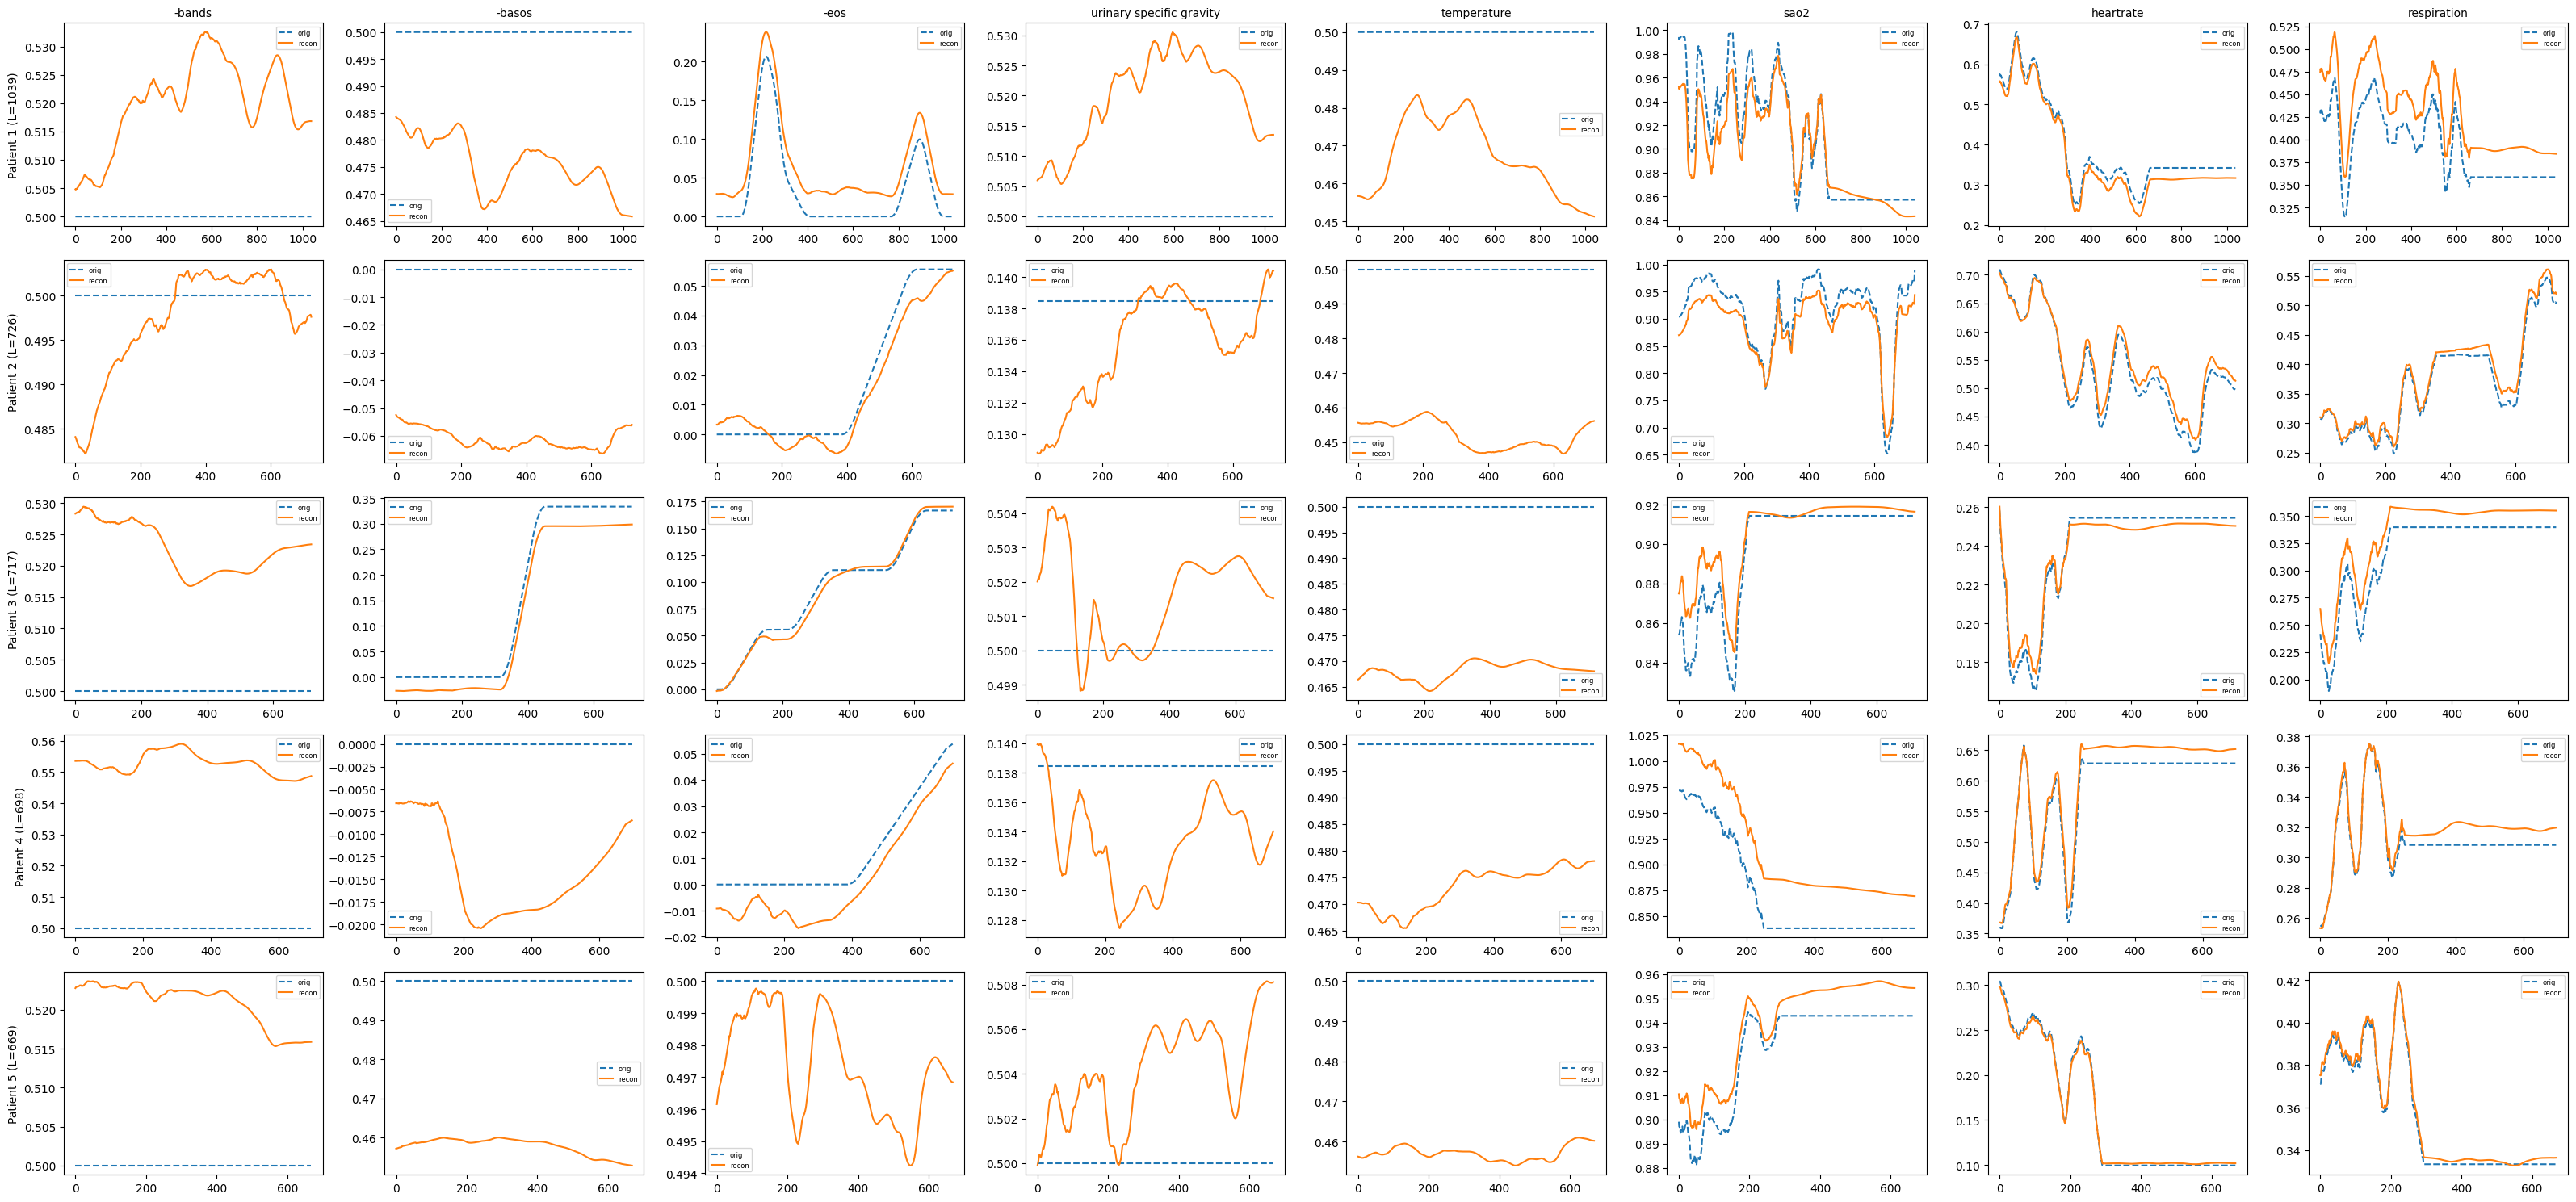

In [8]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model3, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 309494 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): -0.0460
  Std (overall): 0.6322
  Per-dim mean:
tensor([-0.7274,  0.0923, -0.3572,  0.6946,  0.3392, -0.0332, -0.4756, -0.5911,
        -0.1693,  0.1198, -0.8674,  0.3919, -0.1137, -0.5144, -0.6580, -0.0181,
        -0.8774,  0.8094,  0.1126,  0.1695, -0.9666,  0.1658,  0.7350, -0.0821,
        -0.4130,  0.1772, -0.4729,  0.0339, -0.5885,  0.6257, -0.7038, -0.2371,
        -1.1584,  0.0483, -0.3030, -1.4215,  0.1161,  1.0902, -0.2353, -0.2941,
         0.3933,  1.2408, -0.5044, -0.4815, -0.3721,  0.7515, -0.2994, -0.1461,
         0.1345, -0.2956, -0.0837,  0.0712,  0.0915, -0.2869, -1.1040,  0.1176,
         0.8992, -0.8337,  0.9934,  0.5881,  0.2107, -0.0785, -0.1526, -0.5024,
        -0.2877,  1.3283, -0.1694, -0.4635, -0.5296, -0.7106,  0.1064, -0.5221,
         0.2738, -1.1841,  0.4631, -0.5274,  1.0160,  0.0399,  1.6599, -0.5758,
         0.5939,  0.5350,  1.0785,  0.4

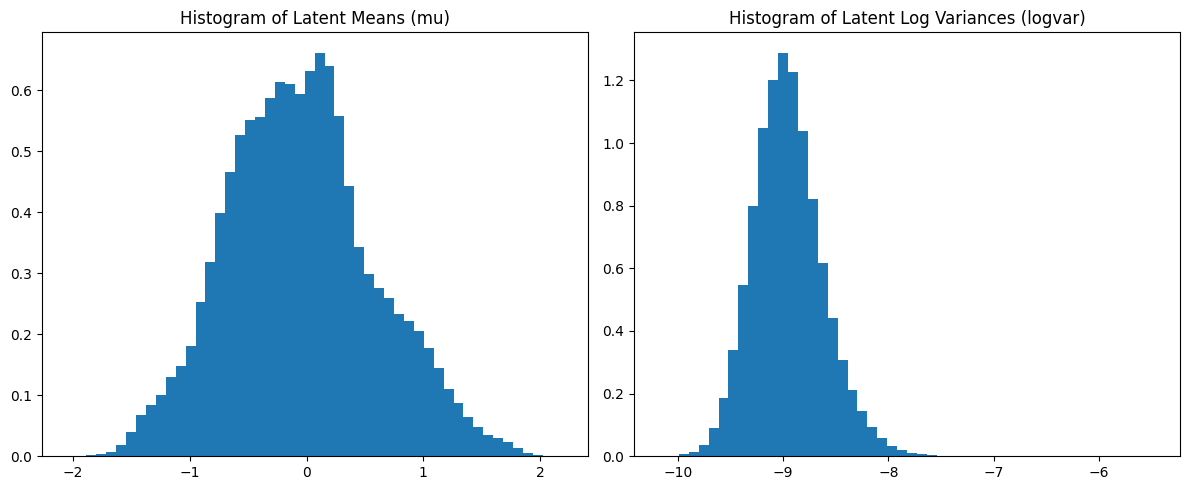

In [9]:
analyze_latent_stats(model1, train_loader, device, num_batches_to_analyze=20)

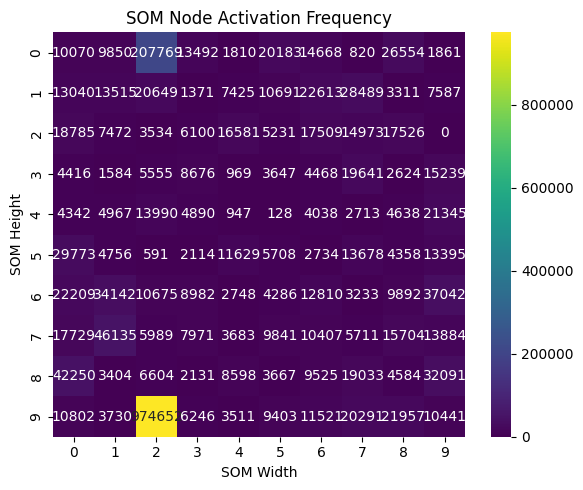

In [10]:
activation_map = compute_som_activation_heatmap(model3,train_loader, device)
plot_som_activation_heatmap(activation_map)

z_all shape: (230791, 128)
y_all shape: (230791,)


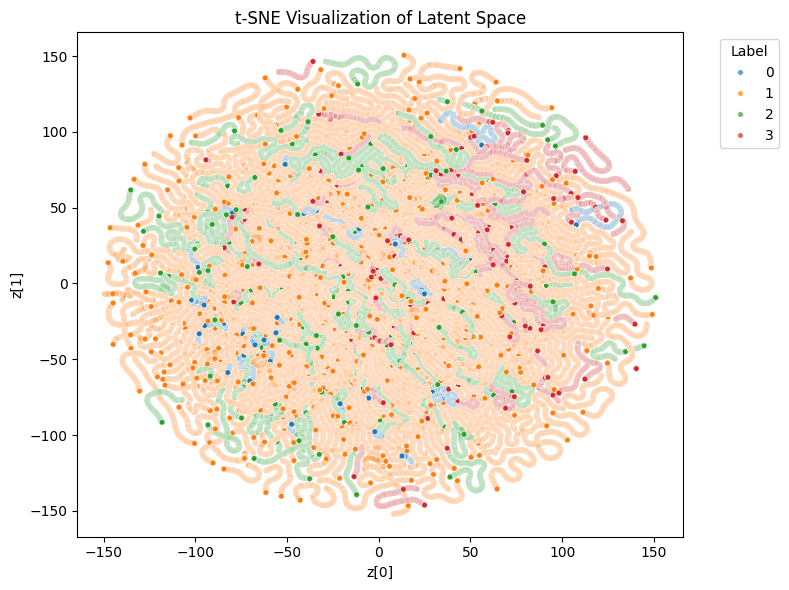

In [11]:
z_all, y_all = collect_latents(model3, data_loader=train_loader, device=device, max_batches=15)
plot_tsne(z_all, y_all)

/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


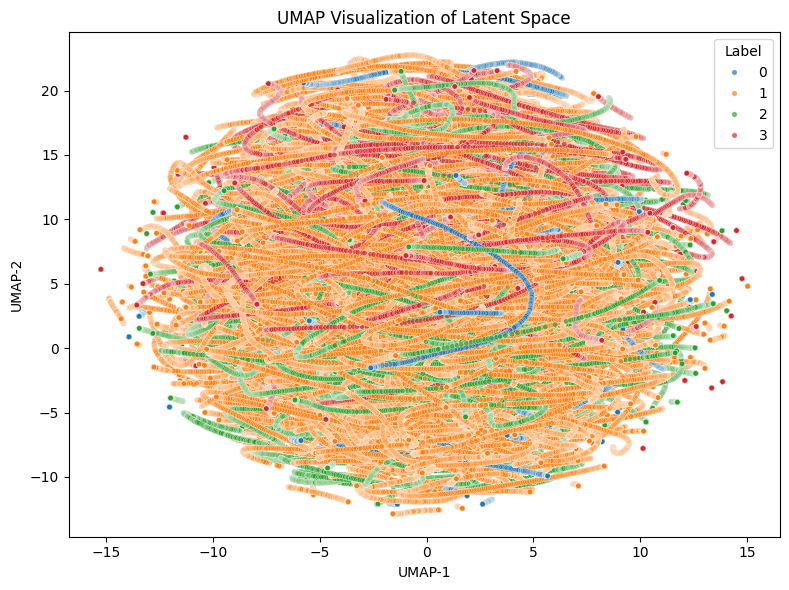

In [12]:
plot_umap(z_all, y_all)
